In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
from os import path
import yaml

Read in all parsed training data

In [2]:
#df = pd.read_csv(path.join("..", "from_arc", "parsed_wback.csv"), index_col=False)
df = pd.read_csv(path.join("..", "from_groot", "groot_wback_e100.csv"), index_col=False)
df.drop(columns=["Unnamed: 0"], inplace=True)
df

,label,version,fold,hparams_batch_size,hparams_cuda,hparams_data_dirs,hparams_early_stopping_patience,hparams_epochs,hparams_folds,hparams_hours_per_fold,...,hparams_blocks_down,hparams_blocks_up,hparams_dice_loss,hparams_image_size,hparams_init_filters,hparams_model_architecture,hparams_unet_r_feature_size,hparams_unet_r_hidden_size,hparams_unet_r_mlp_dim,hparams_unet_r_num_heads
0,unet_3d_knee_wback_e100_transfer_cv,1701805636,0,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,1000,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,unet_3d_knee_wback_e100_transfer_cv,1701805636,1,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,1000,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,unet_3d_knee_wback_e100_transfer_cv,1701805636,2,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,1000,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,unet_3d_knee_wback_e100_transfer_cv,1701805636,3,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,1000,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,unet_3d_knee_wback_e100_transfer_cv,1701805636,4,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,1000,5,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,unetr_3d_knee_wback_e100_base_cv,1702070189,0,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,50,5,4,...,NaN,NaN,False,"[64, 64, 64]",NaN,unet-r,16.0,768.0,3072.0,12.0
321,unetr_3d_knee_wback_e100_base_cv,1702070189,1,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,50,5,4,...,NaN,NaN,False,"[64, 64, 64]",NaN,unet-r,16.0,768.0,3072.0,12.0
322,unetr_3d_knee_wback_e100_base_cv,1702070189,2,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,50,5,4,...,NaN,NaN,False,"[64, 64, 64]",NaN,unet-r,16.0,768.0,3072.0,12.0
323,unetr_3d_knee_wback_e100_base_cv,1702070189,3,16,True,['/home/njneetes/scratch/auto_peri_knee/data/s...,40,50,5,4,...,NaN,NaN,False,"[64, 64, 64]",NaN,unet-r,16.0,768.0,3072.0,12.0


Separate out the base models, find the best version of each architecture

In [3]:
base = df[df["label"].apply(lambda x: "_base_" in x)]

base = base[[
    "label", "version", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
base = base.groupby(["label", "version"]).mean().drop(columns=["fold"])
base = base[
    base.groupby(["label"])["metrics_val_dsc_0_epoch_final"].transform(max) 
    == base["metrics_val_dsc_0_epoch_final"]
].dropna()
base = base.reset_index()

base["label"] = base["label"].apply(lambda x: x[0:-27])

best_base_models = [(l,v) for l,v in zip(base["label"], base["version"])]

base = df[df["label"].apply(lambda x: "_base_" in x)]
base = base[[
    "label", "version", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
base["label"] = base["label"].apply(lambda x: x[0:-27])

base_tmp = pd.DataFrame()

for l, v in best_base_models:
    base_tmp = base_tmp.append(base[(base["label"]==l) & (base["version"]==v)])

base = base_tmp

labels_renaming = {
    "unet": "UNet",
    "unetpp": "UNet++",
    "unetr": "UNETR",
    "segresnetvae": "SegResNetVAE",
    "segan": "SeGAN"
}
base = base.replace({"label": labels_renaming})

base = base.rename(
    columns = {
        "metrics_val_dsc_0_epoch_final": "cort DSC",
        "metrics_val_dsc_1_epoch_final": "trab DSC",
        "metrics_val_dsc_2_epoch_final": "back DSC"
    }
)

base["training"] = "from-scratch"

base

,label,version,fold,cort DSC,trab DSC,back DSC,training
70,SeGAN,1701890757,0,0.865830,0.955741,0.980979,from-scratch
71,SeGAN,1701890757,1,0.866471,0.966887,0.985465,from-scratch
72,SeGAN,1701890757,2,0.857421,0.965832,0.984279,from-scratch
73,SeGAN,1701890757,3,0.871209,0.974294,0.988725,from-scratch
74,SeGAN,1701890757,4,0.892259,0.949623,0.980273,from-scratch
115,SegResNetVAE,1701911178,0,0.581973,0.858233,0.911014,from-scratch
116,SegResNetVAE,1701911178,1,0.668759,0.856673,0.936013,from-scratch
117,SegResNetVAE,1701911178,2,0.735949,0.855394,0.916696,from-scratch
118,SegResNetVAE,1701911178,3,0.635283,0.841458,0.934620,from-scratch
119,SegResNetVAE,1701911178,4,0.692824,0.923879,0.955507,from-scratch


Separate out the transfer models

In [4]:
transfer = df[df["label"].apply(lambda x: "_transfer_" in x)]

transfer = transfer[[
    "label", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]

transfer["label"] = transfer["label"].apply(lambda x: x[0:-31])

transfer = transfer.replace({"label": labels_renaming})

transfer = transfer.rename(
    columns = {
        "metrics_val_dsc_0_epoch_final": "cort DSC",
        "metrics_val_dsc_1_epoch_final": "trab DSC",
        "metrics_val_dsc_2_epoch_final": "back DSC",
    }
)

transfer["training"] = "transfer"

transfer

,label,fold,cort DSC,trab DSC,back DSC,training
0,UNet,0,0.865503,0.951420,0.980403,transfer
1,UNet,1,0.875413,0.965738,0.991168,transfer
2,UNet,2,0.867066,0.959672,0.987269,transfer
3,UNet,3,0.877324,0.963948,0.983817,transfer
4,UNet,4,0.856959,0.967327,0.985156,transfer
5,UNet++,0,0.882939,0.980221,0.992559,transfer
6,UNet++,1,0.896627,0.979669,0.983947,transfer
7,UNet++,2,0.892220,0.964974,0.987819,transfer
8,UNet++,3,0.884005,0.972007,0.994403,transfer
9,UNet++,4,0.888495,0.979007,0.994407,transfer


Bring it all back together into one dataframe for analysis

In [5]:
df_combined = pd.concat([base.drop(columns=["version"]), transfer], ignore_index=True)
df_combined

,label,fold,cort DSC,trab DSC,back DSC,training
0,SeGAN,0,0.865830,0.955741,0.980979,from-scratch
1,SeGAN,1,0.866471,0.966887,0.985465,from-scratch
2,SeGAN,2,0.857421,0.965832,0.984279,from-scratch
3,SeGAN,3,0.871209,0.974294,0.988725,from-scratch
4,SeGAN,4,0.892259,0.949623,0.980273,from-scratch
5,SegResNetVAE,0,0.581973,0.858233,0.911014,from-scratch
6,SegResNetVAE,1,0.668759,0.856673,0.936013,from-scratch
7,SegResNetVAE,2,0.735949,0.855394,0.916696,from-scratch
8,SegResNetVAE,3,0.635283,0.841458,0.934620,from-scratch
9,SegResNetVAE,4,0.692824,0.923879,0.955507,from-scratch


Now we can generate a bar plot to compare the models for how they predict each mask:

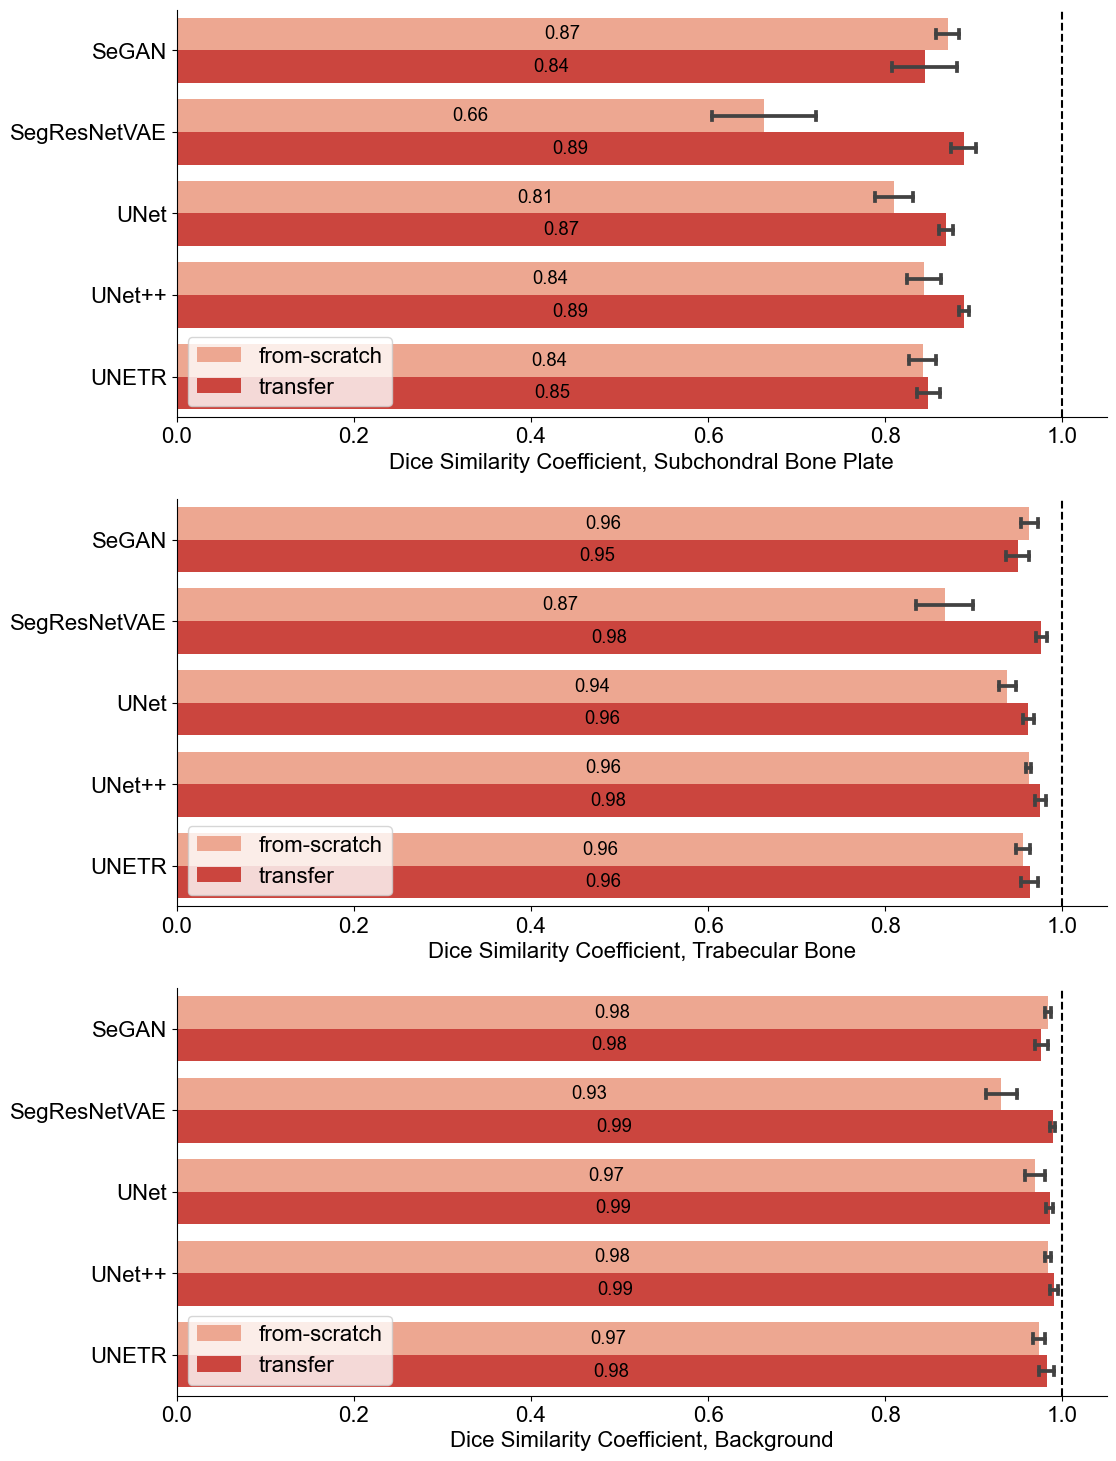

In [6]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Arial',
      'font.size' : 16}
plt.rcParams.update(rc)

metrics = {
    "cort DSC": "Dice Similarity Coefficient, Subchondral Bone Plate", 
    "trab DSC": "Dice Similarity Coefficient, Trabecular Bone", 
    "back DSC": "Dice Similarity Coefficient, Background"
}

fig, axs = plt.subplots(3,1,figsize=(12,18))

for metric, ax in zip(metrics, axs):

    ax.axvline(1, linestyle="--", c="k")
    ax = sns.barplot(
        ax=ax, data=df_combined, y="label", x=metric, hue="training", palette="Reds",
        errorbar="sd", capsize=0.1
    )
    #ax.legend_.remove()
    ax.legend(loc="lower left")
    
    ax.set(
        ylabel="",
        xlabel=metrics[metric]
    )

    for i in ax.containers:
        ax.bar_label(i, fmt="%0.2f", padding=0, label_type="center", fontsize="small")

    ax.grid(axis="x")
    sns.despine()

#ax.legend(loc="lower left")

plt.show()

In [7]:
df_combined_long = pd.melt(
    df_combined,
    id_vars=["label", "fold", "training"],
    var_name="Compartment",
    value_name="Dice Similarity Coefficient"
)

compartment_names = {
    "cort DSC": "Subchondral Bone Plate", 
    "trab DSC": "Trabecular Bone", 
    "back DSC": "Background"
}

df_combined_long.rename(
    columns={
        "training": "Training Method",
        "label": "Model Architecture",
        "fold": "Fold"
    }, 
    inplace=True
)

df_combined_long["Compartment"] = df_combined_long["Compartment"].apply(lambda x: compartment_names[x])

df_combined_long

,Model Architecture,Fold,Training Method,Compartment,Dice Similarity Coefficient
0,SeGAN,0,from-scratch,Subchondral Bone Plate,0.865830
1,SeGAN,1,from-scratch,Subchondral Bone Plate,0.866471
2,SeGAN,2,from-scratch,Subchondral Bone Plate,0.857421
3,SeGAN,3,from-scratch,Subchondral Bone Plate,0.871209
4,SeGAN,4,from-scratch,Subchondral Bone Plate,0.892259
...,...,...,...,...,...
145,SegResNetVAE,0,transfer,Background,0.988728
146,SegResNetVAE,1,transfer,Background,0.993142
147,SegResNetVAE,2,transfer,Background,0.985864
148,SegResNetVAE,3,transfer,Background,0.990057


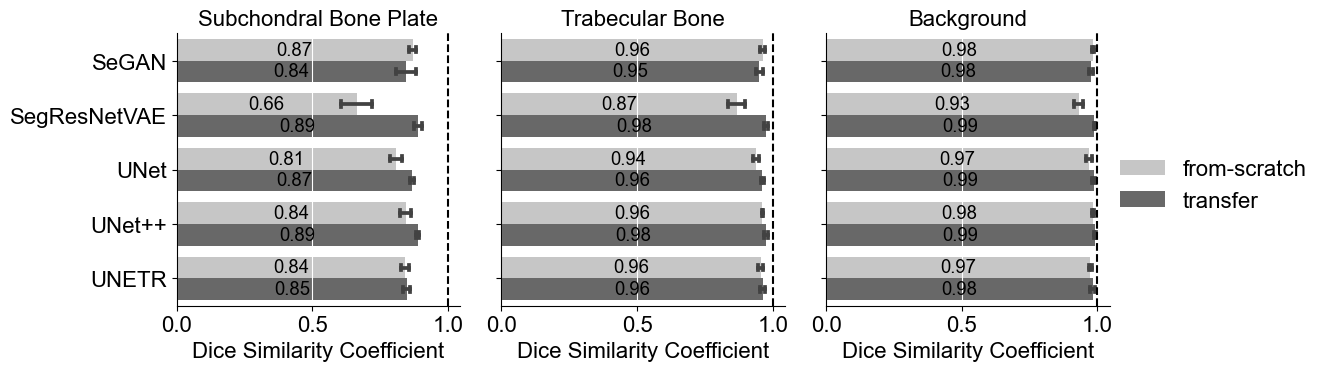

In [8]:
rc = {
    'figure.figsize':(10,5),
    'axes.facecolor':'white',
    'axes.grid' : True,
    'grid.color': '1',
    'font.family':'Arial',
    'font.size' : 16,
    'legend.frameon': True,
}
plt.rcParams.update(rc)

#sns.set_style('darkgrid', {'legend.frameon':True})

facet_grid = sns.catplot(
    data=df_combined_long, kind="bar",
    y="Model Architecture", x="Dice Similarity Coefficient", 
    hue="Training Method", palette="Greys",
    col="Compartment",
    errorbar="sd", capsize=0.1,
    height=4, legend=False
)

for ax in facet_grid.axes.ravel():
    for i in ax.containers:
        ax.bar_label(i, fmt="%0.2f", padding=0, label_type="center", fontsize="small")

facet_grid.refline(x=1, color="k", linestyle="--")
facet_grid.set_axis_labels(y_var="")
facet_grid.set_titles(col_template="{col_name}")

facet_grid.add_legend(facecolor="w", edgecolor="k")

#plt.tight_layout()
plt.savefig("model_validation_results.png", dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

In [9]:
df_combined_long.to_csv("groot_wback_e100_long.csv")

In [10]:
df_combined_long[
    (df_combined_long["Model Architecture"] == "SegResNetVAE")
    & (df_combined_long["Training Method"] == "transfer")
    & (df_combined_long["Compartment"] == "Subchondral Bone Plate")
]["Dice Similarity Coefficient"].mean()

0.8888051748275757

In [11]:
df_combined_long[
    (df_combined_long["Model Architecture"] == "SegResNetVAE")
    & (df_combined_long["Training Method"] == "transfer")
    & (df_combined_long["Compartment"] == "Subchondral Bone Plate")
]["Dice Similarity Coefficient"].std()

0.014088021725449833

In [12]:
df_combined_long[
    (df_combined_long["Model Architecture"] == "UNet++")
    & (df_combined_long["Training Method"] == "transfer")
    & (df_combined_long["Compartment"] == "Subchondral Bone Plate")
]["Dice Similarity Coefficient"].mean()

0.8888571977615356

In [13]:
df_combined_long[
    (df_combined_long["Model Architecture"] == "UNet++")
    & (df_combined_long["Training Method"] == "transfer")
    & (df_combined_long["Compartment"] == "Subchondral Bone Plate")
]["Dice Similarity Coefficient"].std()

0.005709195895065792